# Plotting glider cross-sections

_Written by Lori Garzio, June 15, 2023_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook shows you how to plot a cross-section of glider temperature. In this example we will be using data manually downloaded from the [IOOS Glider DAC ERDDAP server](https://gliders.ioos.us/erddap/index.html). See the download_data_dac notebook for detailed instructions.

In [1]:
# import required packages
import os
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
plt.rcParams.update({'font.size': 12})  # all font sizes for the plot will be 12 unless otherwise specified

Specify where you want the plot to be saved on your local machine, and the file path for the dataset you would like to plot. Load the dataset using xarray and look at it for variables, time range, etc.

In [2]:
save_dir = '/Users/garzio/Documents/rucool/gliderplots'
f = '/Users/garzio/Documents/rucool/gliderdata/ru30-20210716T1804-delayed.nc'
ds = xr.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:                         (row: 1894148)
Dimensions without coordinates: row
Data variables: (12/28)
    time                            (row) datetime64[ns] ...
    latitude                        (row) float64 ...
    longitude                       (row) float64 ...
    depth                           (row) float32 ...
    aragonite_saturation_state      (row) float32 ...
    chlorophyll_a                   (row) float32 ...
    ...                              ...
    salinity_interpolated           (row) float32 ...
    salinity_lag_shifted            (row) float32 ...
    temperature                     (row) float32 ...
    temperature_interpolated        (row) float32 ...
    temperature_lag_shifted         (row) float32 ...
    total_alkalinity                (row) float32 ...
Attributes: (12/59)
    acknowledgment:                This deployment supported by the NOAA Ocea...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    comment:                       Glider operated by the Rutgers University ...
    contributor_name:              Grace Saba, Theodore Thompson, Dave Aragon...
    ...                            ...
    subsetVariables:               wmo_id,trajectory,profile_id,time,latitude...
    summary:                       This project is conducting seasonal deploy...
    time_coverage_end:             2021-08-20T16:56:16.31Z
    time_coverage_start:           2021-07-16T18:06:48.11Z
    title:                         ru30-20210716T1804-delayed
    Westernmost_Easting:           -74.59385

You can also get a list of the variables included in the file by using ds.data_vars

In [3]:
list(ds.data_vars)

['time',
 'latitude',
 'longitude',
 'depth',
 'aragonite_saturation_state',
 'chlorophyll_a',
 'conductivity',
 'conductivity_lag_shifted',
 'density',
 'density_lag_shifted',
 'depth_interpolated',
 'instrument_ctd',
 'instrument_flbbcd',
 'instrument_optode',
 'instrument_ph',
 'pH_corrected',
 'pH_raw',
 'pH_reference_voltage_corrected',
 'pH_reference_voltage_raw',
 'pressure',
 'pressure_interpolated',
 'salinity',
 'salinity_interpolated',
 'salinity_lag_shifted',
 'temperature',
 'temperature_interpolated',
 'temperature_lag_shifted',
 'total_alkalinity']

Swap the dimensions to 'time'. This makes it easier to subset the dataset by time if you want to do that for any reason. 

In [4]:
ds = ds.swap_dims({'row': 'time'})

Get the deployment name from the global attributes from the file. This is always good to have for file naming and adding titles to plots.

In [5]:
deployment_id = ds.title
deployment_id

'ru30-20210716T1804-delayed'

Next, grab the temperature variable. The attributes will give you some important information about the variable, such as units.

In [6]:
temp = ds.temperature
temp

<xarray.DataArray 'temperature' (time: 1894148)>
[1894148 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2021-07-16T18:06:48.116182784 ... 2021-08-...
Attributes: (12/13)
    _ChunkSizes:       198
    actual_range:      [ 8.375  26.2883]
    colorBarMaximum:   32.0
    colorBarMinimum:   0.0
    comment:           Suspect/failed IOOS QC values, and values flagged by a...
    instrument:        instrument_ctd
    ...                ...
    long_name:         Sea Water Temperature
    observation_type:  measured
    standard_name:     sea_water_temperature
    units:             Celsius
    valid_max:         40.0
    valid_min:         -5.0

The function below will generate a cross-section scatter plot with time on the x-axis, a depth variable you specify on the y-axis and the variable input as the color. There are usually several depth variables in the files (pressure, depth, depth_interpolated, etc). I usually like to plot against interpolated depth because sometimes the timestamps for data from the non-CTD sensors (like dissolved oxygen or pH) are slightly offset. This isn't always an issue, and in this case it probably won't be an issue because pressure and temperature are both measured by the CTD. But to be safe, and to make sure all of your science data always have an associated depth variable, I like to plot against interpolated depth.

In [7]:
def plot_xsection_timeseries(variable, depthvar, colormap, title, save_name):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.subplots_adjust(left=0.08, right=0.92)
    xc = ax.scatter(variable.time.values, depthvar, c=variable.values, cmap=colormap)  # plot the data
    ax.invert_yaxis()  # invert the y-axis
    ax.set_ylabel(depthvar.name) # label the y-axis (can change the font size using "fontsize=14")
    
    # format colorbar
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
    fig.add_axes(cax)
    label = f'{temp.long_name} ({temp.units})' # make the label for the colorbar
    plt.colorbar(xc, cax=cax, label=label)  # add the colorbar label
    
    # format the dates on the x-axis
    xfmt = mdates.DateFormatter('%m/%d\n%Y')
    ax.xaxis.set_major_formatter(xfmt)
    
    ax.set_title(title, fontsize=16)  # add a title with a larger font
    
    # save the plot to your local machine
    plt.savefig(save_name, dpi=300)

Now, we'll specify all of the inputs to the function to generate our temperature cross-section plot. First, define the name of the file using the deployment ID and variables name. I'm also going to use the deployment ID as the plot title.

For this colormap we're using the [cmocean](https://matplotlib.org/cmocean/) "thermal" colormap. Check out the documentation for all of the other colormaps that could be useful for plotting additional glider data.

Then, run the function using the appropriate inputs.

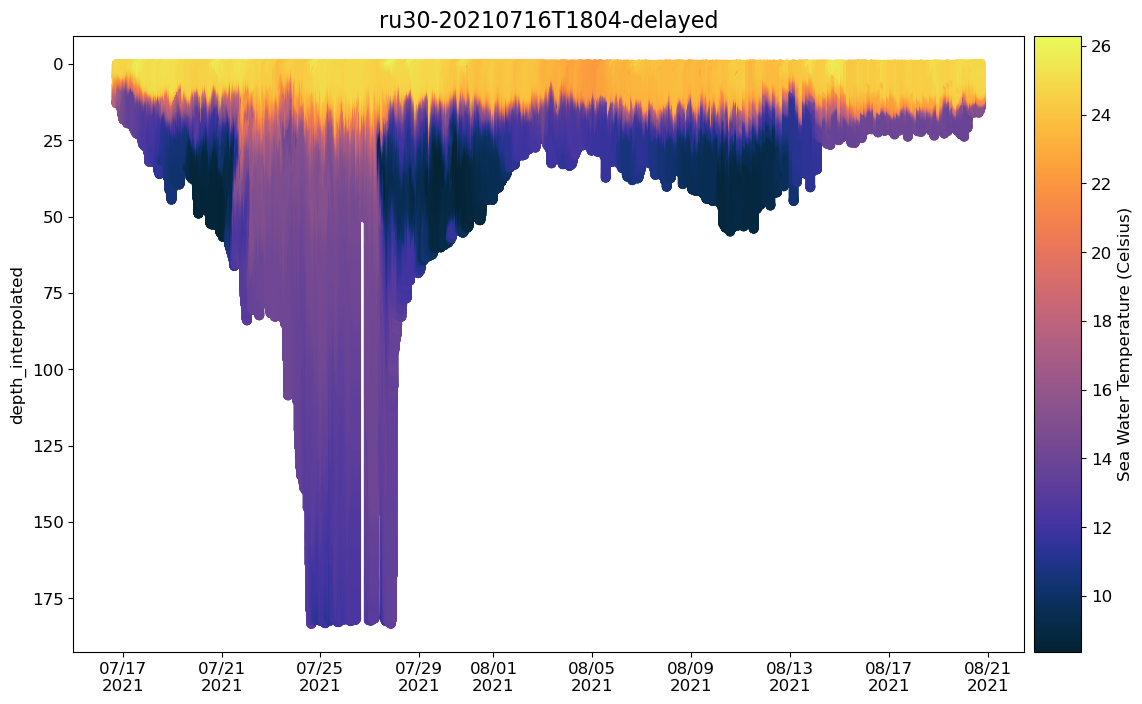

In [8]:
fname = f'{deployment_id}_{temp.name}_xsection_timeseries.png'
sname = os.path.join(save_dir, fname)

cmap = cmo.cm.thermal

# run the function
plot_xsection_timeseries(temp, ds.depth_interpolated, cmap, deployment_id, sname)